<a href="https://colab.research.google.com/github/BornFromAshes/BERT-Recommendation-System/blob/main/bert_recomm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install tf-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00


In [ ]:
# Importing libraries
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas()
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding, TFAutoModel
from datasets import load_dataset
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score
plt.style.use('ggplot')
# os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["TF_USE_LEGACY_KERAS"] = "1"

### Load prepared data

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/MyDrive/train.pkl', 'rb') as f:
    train = pickle.load(f)

Mounted at /content/drive


In [ ]:
df = pd.DataFrame(train)
df = df.dropna()

In [ ]:
users = df.user_id.unique()
users = np.random.choice(users,size = 4000, replace=False)
df = df[df.user_id.isin(users)].reset_index(drop=True)

news = df.news_id.unique()
news = np.random.choice(news,size = 2000, replace=False)
df = df[df.news_id.isin(news)].reset_index(drop=True)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
# n=64
# m=4*n
# result = df.groupby('user_id').filter(lambda x: (x['Label'] == 1).sum() >= n and (x['Label'] == 0).sum() >= m)['user_id'].unique()
# df = df.loc[df.user_id.isin(result)].reset_index(drop=True)

In [ ]:
df.shape

(33399, 5)

In [ ]:
data_label_1 = df[df['Label'] == 1]
data_label_0 = df[df['Label'] == 0]
_, l0 = train_test_split(data_label_0, test_size=4*data_label_1.shape[0], random_state=100, shuffle=True)# stratify=data_label_0.user_id

train_df = pd.concat([data_label_1, l0])
train_df = train_df.sample(frac = 1).reset_index(drop=True) #shuffle & reset index

In [ ]:
num_users = train_df.user_id.nunique()
num_news = train_df.news_id.nunique()

In [ ]:
train_df.shape

(6315, 5)

In [ ]:
user_ids = train_df.user_id.unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
news_ids = train_df.news_id.unique().tolist()
news2news_encoded = {x: i for i, x in enumerate(news_ids)}
news_encoded2news = {i: x for i, x in enumerate(news_ids)}
train_df.user_id = train_df.user_id.map(user2user_encoded)
train_df.news_id = train_df.news_id.map(news2news_encoded)

In [ ]:
# def stratified_sample_df(df, col, n_samples):
#     n = min(n_samples, df[col].value_counts().min())
#     df_ = df.groupby(col).apply(lambda x: x.sample(n))
#     df_.index = df_.index.droplevel(0)
#     return df_

In [ ]:
# def sample_with_fraction(df, col, n_sample, frac):
#     # Separate the DataFrame based on the values in col
#     df_0 = df[df[col] == 0]
#     df_1 = df[df[col] == 1]
#     # Calculate the number of samples for each value based on the fraction
#     n_sample_1 = int(n_sample * frac)
#     n_sample_0 = n_sample - n_sample_1
#     # Sample n_sample samples with frac fraction of them having col equal to 1
#     sample_df_1 = df_1.sample(n=n_sample_1, replace=True)
#     sample_df_0 = df_0.sample(n=n_sample_0, replace=True)
#     # Concatenate the sampled DataFrames
#     sampled_df = pd.concat([sample_df_1, sample_df_0])
#     return sampled_df

In [ ]:
# train_df.drop(['user_id'], axis=1, inplace=True)
# # train_df = stratified_sample_df(train_df,"Label", 1000) # n for each label => 2 x n total
# train_df = sample_with_fraction(train_df, "Label", 1000, 0.25) # 0.25 of samples have label=1
# # train_df = train_df.sample(4000000)
# train_df = train_df.reset_index(drop=True)
# train_df = train_df.dropna()

In [ ]:
train_df.head(5)

,user_id,news_id,User_Sentence,News_Sentence,Label
0,0,0,A Texas mom is going to prison after putting h...,A Man and His Shelby G.T. 350 51 Years On,0
1,1,1,Prince Harry acknowledges tensions with Willia...,Biggest celeb weddings of the last decade,0
2,2,2,Cause determined in Jessi Combs' fatal speed r...,I Was A Psychic Phone Line Operator. Here's Wh...,1
3,3,3,Boxer Patrick Day dies after suffering traumat...,Emma Stone transforms into a young Cruella de ...,0
4,4,4,The Cost of Trump's Aid Freeze in the Trenches...,Monday Night Football Week 10: Seahawks at 49e...,0


In [ ]:
# Splitting the data into train and validation set
train_data, test_val_data = train_test_split(train_df, test_size=0.4, stratify=train_df['Label'], random_state=100, shuffle=True)
val_data, test_data = train_test_split(test_val_data, test_size=0.5, stratify=test_val_data['Label'], random_state=100, shuffle=True)


train_data.to_csv('train_clean.csv', index=False)
val_data.to_csv('val_clean.csv',index=False)
test_data.to_csv('test_clean.csv',index=False)

In [ ]:
dataset = load_dataset('csv', data_files={'train': 'train_clean.csv','valid':'val_clean.csv',})
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['user_id', 'news_id', 'User_Sentence', 'News_Sentence', 'Label'],
        num_rows: 3789
    })
    valid: Dataset({
        features: ['user_id', 'news_id', 'User_Sentence', 'News_Sentence', 'Label'],
        num_rows: 1263
    })
})

In [ ]:
# Model set and batch size
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

In [ ]:
# Initializing the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
special_token = "[NSEP]"
num_added_tokens = tokenizer.add_special_tokens({"additional_special_tokens": [special_token]})

In [ ]:
# Running tokenizer on sample data
tokenizer(train_df.News_Sentence[0], train_df.User_Sentence[0],padding='max_length', truncation=True, max_length=128, return_tensors='tf')

{'input_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[  101,  1037,  2158,  1998,  2010, 15294,  1043,  1012,  1056,
         1012,  8698,  4868,  2086,  2006,   102,  1037,  3146,  3566,
         2003,  2183,  2000,  3827,  2044,  5128,  2014,  2365,  2083,
        14203,  2966,  8853, 30522,  4812,  4247,  2046,  5823,  2008,
         2730,  2450,  1010,  1017,  2336,  2220,  4465,  2851, 30522,
         7910,  1011,  2821,   999, 13223,  5754, 27118,  3676,  4212,
         2006,  1005,  5613,  2007,  1996,  3340,  1005,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

In [ ]:
def preprocess_function(records):
    return tokenizer(records['News_Sentence'], records['User_Sentence'], truncation=True, max_length = 512)

In [ ]:
encoded_dataset = dataset.map(preprocess_function, batched=True, )

Map:   0%|          | 0/3789 [00:00<?, ? examples/s]

Map:   0%|          | 0/1263 [00:00<?, ? examples/s]

In [ ]:
# Preprocessed dataset
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['user_id', 'news_id', 'User_Sentence', 'News_Sentence', 'Label', 'input_ids', 'attention_mask'],
        num_rows: 3789
    })
    valid: Dataset({
        features: ['user_id', 'news_id', 'User_Sentence', 'News_Sentence', 'Label', 'input_ids', 'attention_mask'],
        num_rows: 1263
    })
})

In [ ]:
encoded_dataset.save_to_disk('/content/drive/MyDrive/encoded_dataset.hf')

NameError: name 'encoded_dataset' is not defined

In [ ]:
from datasets import load_from_disk

encoded_dataset = load_from_disk('/content/drive/MyDrive/encoded_dataset.hf')

In [ ]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['user_id', 'news_id', 'User_Sentence', 'News_Sentence', 'Label', 'input_ids', 'attention_mask'],
        num_rows: 645765
    })
    valid: Dataset({
        features: ['user_id', 'news_id', 'User_Sentence', 'News_Sentence', 'Label', 'input_ids', 'attention_mask'],
        num_rows: 215255
    })
})

In [ ]:
# Columns added by tokenizer
col_tokenizer = encoded_dataset.column_names['train'][5:]
col_tokenizer

['input_ids', 'attention_mask']

### Data padding and batching

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf",)

In [ ]:
tf_train_dataset = encoded_dataset["train"].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'user_id', 'news_id'],
    label_cols=["Label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
tf_validation_dataset = encoded_dataset["valid"].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'user_id', 'news_id'],
    label_cols=["Label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:401: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
# sample train batch
sample_batch=next(iter(tf_train_dataset))
sample_batch

({'user_id': <tf.Tensor: shape=(16,), dtype=int64, numpy=
  array([1188,  846,  844,  410,   56,   69,  170,  537,  515,  363, 1097,
         1297,  667,  737,  672,    9])>,
  'news_id': <tf.Tensor: shape=(16,), dtype=int64, numpy=
  array([ 26, 114,  13,  41,  71, 400,  81,  50, 112, 114,  72, 555,  20,
          29, 179,  19])>,
  'input_ids': <tf.Tensor: shape=(16, 512), dtype=int64, numpy=
  array([[  101,  2005,  2093, ...,     0,     0,     0],
         [  101,  5947,  3825, ...,     0,     0,     0],
         [  101,  1996,  1019, ...,     0,     0,     0],
         ...,
         [  101,  4259,  2457, ...,     0,     0,     0],
         [  101,  1996,  2087, ...,     0,     0,     0],
         [  101,  2190,  2406, ..., 18623, 30522,   102]])>,
  'attention_mask': <tf.Tensor: shape=(16, 512), dtype=int64, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1,

In [ ]:
# sample decoded string
tokenizer.decode(sample_batch[0]['input_ids'][0])

"[CLS] for three decades, one man, now 75, has cared for philly's vietnam and korean war memorials [SEP] patrick day in coma after suffering brutal knockout [NSEP] mansions for sale with massive secrets [NSEP] john krasinski shares the secret to his 9 - year marriage to emily blunt [NSEP] police recover 1981 chevy corvette stolen nearly 40 years ago [NSEP] bruce willis brought demi moore to tears after reading her book [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [ ]:
train_df.Label.sum()

1263

In [ ]:
# Percentage of class==1 in dataset
num_classes = 2
train_df.Label.sum()/len(train_df)

0.2

### Loading the model checkpoint


In [ ]:
# from tensorflow.keras import ops
from tensorflow import keras
nbert = TFAutoModel.from_pretrained(model_checkpoint)
nbert.resize_token_embeddings(len(tokenizer))
class CustomBERTModel(keras.Model):
    def __init__(self, num_users, num_news, embedding_size):
        super(CustomBERTModel, self).__init__()
        self.bert = nbert#TFAutoModel.from_pretrained(model_checkpoint)#
          ### New layers:
        self.linear1 = keras.layers.Dense(256)
        self.linear2 = keras.layers.Dense(1) ## 2 is the number of classes in this example

        self.num_users = num_users
        self.num_news = num_news
        self.embedding_size = embedding_size
        self.user_embedding = keras.layers.Embedding(
            num_users +1,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
#         self.user_bias = keras.layers.Embedding(num_users, 1)
        self.news_embedding = keras.layers.Embedding(
            num_news+1,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
#         self.news_bias = keras.layers.Embedding(num_news, 1)
        self.dot_layer = keras.layers.Dot(axes=1)
    def call(self, inputs, training=False):
          # call expects only one positional argument, so you have to pass in a tuple and unpack. The next parameter is a special reserved training parameter.
        uid = inputs['user_id']
        nid = inputs['news_id']
        ids = inputs['input_ids']
        mask = inputs['attention_mask']


        user_vector = self.user_embedding(uid)
#         user_bias = self.user_bias(uid)
        news_vector = self.news_embedding(nid)
#         news_bias = self.news_bias(nid)

        # dot_user_news = self.dot_layer([user_vector, news_vector])
#         x = dot_user_news + user_bias + news_bias
        # Add all the components (including bias)
        xu = user_vector# + user_bias
        xn = news_vector# + news_bias

        sequence_output = self.bert(ids, mask, training=training).last_hidden_state

          # sequence_output has the following shape: (batch_size, sequence_length, 768)

        l_in = tf.concat([xu, xn, sequence_output[:,0,:]], 1)
#         l_in = tf.stack([dot_user_news, sequence_output[:,0,:]])
#         print(l_in.shape)
        linear1_output = self.linear1(l_in) ## extract the 1st token's embeddings
        # l_in = tf.math.multiply(dot_user_news, linear1_output)
        linear2_output = self.linear2(linear1_output)

        return linear2_output

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
model = CustomBERTModel(num_users, num_news,128)
model.layers[0].trainable=True

In [ ]:
model.layers[0]

In [ ]:
checkpoint_path = "/content/drive/MyDrive/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=10000)

In [ ]:
# Downloading the model
# model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels = num_classes)

### Defining the parameters, optimizer and loss function

In [ ]:
num_epochs = 10
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps, power = 2
)

In [ ]:
opt = tf.compat.v1.train.AdamOptimizer(learning_rate=0.00001)
loss = keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, gamma=2, from_logits=True)

In [ ]:
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [ ]:
history=model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=num_epochs)

Epoch 1/10
237/237 [==============================] - 268s 1s/step - loss: 0.0507 - accuracy: 0.7999 - val_loss: 0.0489 - val_accuracy: 0.7997
Epoch 2/10
237/237 [==============================] - 244s 1s/step - loss: 0.0481 - accuracy: 0.7999 - val_loss: 0.0490 - val_accuracy: 0.7997
Epoch 3/10
237/237 [==============================] - 245s 1s/step - loss: 0.0463 - accuracy: 0.7999 - val_loss: 0.0511 - val_accuracy: 0.7997
Epoch 4/10
237/237 [==============================] - 261s 1s/step - loss: 0.0418 - accuracy: 0.8005 - val_loss: 0.0591 - val_accuracy: 0.8005
Epoch 5/10
237/237 [==============================] - 244s 1s/step - loss: 0.0364 - accuracy: 0.8052 - val_loss: 0.0604 - val_accuracy: 0.7997
Epoch 6/10
237/237 [==============================] - 244s 1s/step - loss: 0.0293 - accuracy: 0.8176 - val_loss: 0.0835 - val_accuracy: 0.7933
Epoch 7/10
237/237 [==============================] - 244s 1s/step - loss: 0.0244 - accuracy: 0.8430 - val_loss: 0.1021 - val_accuracy: 0.7815

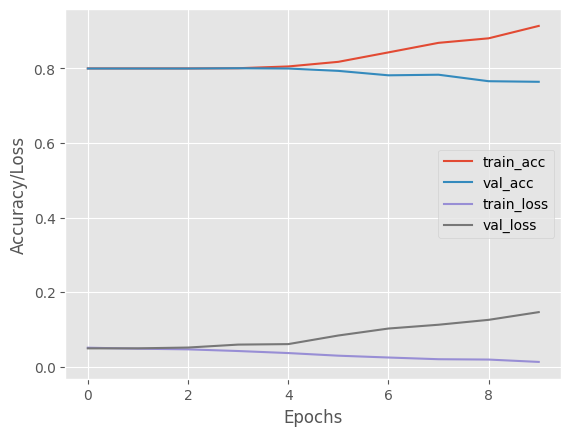

In [ ]:
# Plotting the accuracy, training and validation loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'])
plt.show()

In [ ]:
# # Saving the model
# model.save_pretrained(f"saved_model_epoch{num_epochs}")

In [ ]:
# Loading the Last saved model
# trained_model = TFAutoModelForSequenceClassification.from_pretrained(f'saved_model_epoch{num_epochs}',num_labels = num_classes)

In [ ]:
test_dataset = load_dataset('csv', data_files={'test': 'test_clean.csv'})
test_dataset

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['user_id', 'news_id', 'User_Sentence', 'News_Sentence', 'Label'],
        num_rows: 1263
    })
})

In [ ]:
encoded_test_dataset = test_dataset.map(preprocess_function, batched=True, )

Map:   0%|          | 0/1263 [00:00<?, ? examples/s]

In [ ]:
tf_test_dataset = encoded_test_dataset["test"].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'user_id', 'news_id'],
    label_cols=["Label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:401: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
model.evaluate(tf_test_dataset)

79/79 [==============================] - 25s 316ms/step - loss: 0.1371 - accuracy: 0.7625


[0.13709938526153564, 0.7624703049659729]

In [ ]:
pt=model.predict(tf_test_dataset)

79/79 [==============================] - 28s 316ms/step


In [ ]:
def mrr_score(y_true, y_score):

    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order)
    rr_score = y_true / (np.arange(len(y_true)) + 1)
    return np.sum(rr_score) / (np.sum(y_true)+1e-17)

In [ ]:
import numpy as np
res={}
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

y_pred = sigmoid(pt)

auc = roc_auc_score(test_data["Label"].values, y_pred)
res["auc"] = round(auc, 4)

mean_mrr = np.mean(
    [
        mrr_score(each_labels, each_preds)
        for each_labels, each_preds in zip(test_data["Label"].values, y_pred)
    ]
)

res["mrr"] = round(mean_mrr, 4)

In [ ]:
res

{'auc': 0.5108, 'mrr': 0.1995}